Linear algebra
==============

Silent substitution problems may be solved with linear algebra.

Basic example
-------------

************************************************************
*************** Silent Substitution Problem ****************
************************************************************
Device: BCGAR (8-bit, linear)
Ignoring: ['rh']
Minimising: ['mc', 'lc', 'mel']
Modulating: ['sc']
Target contrast: [ 0.2]
Background: [0.5, 0.5, 0.5, 0.5, 0.5]




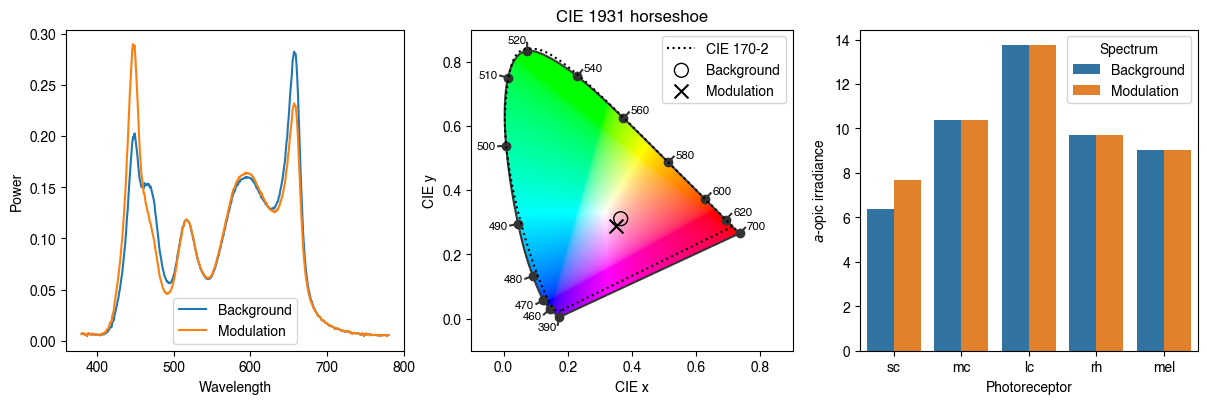

In [1]:
from pysilsub.problems import SilentSubstitutionProblem as SSP

# Instantiate the problem class
ssp = SSP.from_package_data('BCGAR')

# Define problem
ssp.ignore = ['rh']
ssp.modulate = ['sc']
ssp.minimize = ['mc', 'lc', 'mel']
ssp.background = [.5] * ssp.nprimaries
ssp.target_contrast = .2
ssp.print_problem()

# Find solution
solution = ssp.linalg_solve()

# Plot solution
fig = ssp.plot_solution(solution)

In [2]:
print(f'The background settings are: {ssp.w2s(ssp.background)}')
print(f'The modulation settings are: {ssp.w2s(solution)}')

The background settings are: [127, 127, 127, 127, 127]
The modulation settings are: [205, 79, 128, 130, 98]


Worked example
--------------

For a background spectrum we will take the mixture of all primaries at half-max power, $\alpha_{bg} = [.5 \ .5 \ .5 \ .5 \ .5]$. Note that in this case we are not summing the predicted spectra as we'll be doing matrix algebra involving the individual primaries.

In [3]:
abg = [.5, .5, .5, .5, .5]
bg_spds = ssp.predict_multiprimary_spd(abg, nosum=True)
bg_spds

Primary,0,1,2,3,4
Wavelength,,,,,
380,0.001098,0.000856,0.001115,0.001842,0.001736
381,0.001134,0.000933,0.001191,0.002067,0.002040
382,0.000991,0.000838,0.001198,0.001945,0.001812
383,0.001091,0.000828,0.001231,0.001945,0.002044
384,0.000879,0.000745,0.001003,0.001673,0.001556
...,...,...,...,...,...
776,0.000625,0.000533,0.000710,0.002349,0.001355
777,0.000577,0.000525,0.000693,0.002305,0.001301
778,0.000516,0.000398,0.000562,0.002146,0.001093


Next, we'll be needing the spectral sensitivities for the photoreceptors.

In [4]:
from pysilsub.CIE import get_CIES026_action_spectra

sss = get_CIES026_action_spectra()
sss

,sc,mc,lc,rh,mel
Wavelength,,,,,
380,0.0,0.000000,0.000000,5.890000e-04,9.181600e-04
381,0.0,0.000000,0.000000,6.650000e-04,1.045600e-03
382,0.0,0.000000,0.000000,7.520000e-04,1.178600e-03
383,0.0,0.000000,0.000000,8.540000e-04,1.322800e-03
384,0.0,0.000000,0.000000,9.720000e-04,1.483800e-03
...,...,...,...,...,...
776,0.0,0.000002,0.000024,1.730000e-07,2.550000e-08
777,0.0,0.000002,0.000023,1.640000e-07,2.420000e-08
778,0.0,0.000002,0.000021,1.550000e-07,2.290000e-08


The dot product of these matrices, which we will call $A$, contains the *a*-opic irradiances for each primary component of the background spectrum.

In [5]:
A = sss.T.dot(bg_spds)
A

Primary,0,1,2,3,4
sc,3.580009,2.453689,0.211358,0.095264,0.057067
mc,0.627573,1.355843,3.573256,4.683028,0.156777
lc,0.435727,0.873636,2.915142,8.686473,0.853310
rh,1.730730,2.965132,3.638927,1.288265,0.076642
mel,2.094721,3.520715,2.841600,0.509312,0.069365


Now, the unique scaling coefficients for the primaries $\alpha_{sc} = [p_{0} \ p_{1} \ p_{2} \ p_{3} \ p_{4}]$ that must be added to the primary weights for the background $\alpha_{bg}$ for a requested modulation $\beta = [sc \ mc \ lc \ rh \ mel]$, are discovered as $\alpha_{sc} = \beta A^{-1}$.

In [7]:
import numpy as np
import pandas as pd

# Calculate inverse of A
A1 = pd.DataFrame(
    np.linalg.inv(A.values),
    A.columns, 
    A.index)
A1

,sc,mc,lc,rh,mel
Primary,,,,,
0,0.473797,-0.159332,-0.001803,0.993080,-1.104764
1,-0.279487,0.340021,-0.037472,-1.654925,1.750941
2,-0.002424,-0.286409,0.015329,1.342032,-1.022070
3,0.026572,0.502356,-0.059770,-0.855885,0.523675
4,-0.218010,-4.402157,1.767262,5.315177,-3.067724


In [8]:
# Requested modulation for S-cones
requested_contrast = .2

b = np.array([requested_contrast, 0., 0., 0., 0.])

# Scale requested contrasts to percentage of background units
b = A.sum(axis=1).mul(b)

# Calculate the scaling coefficients
asc = A1.dot(b) / 2
asc

Primary
0    0.303106
1   -0.178799
2   -0.001551
3    0.016999
4   -0.139469
dtype: float64

Following on from above, $\alpha_{mod} = \alpha_{bg} + \alpha_{sc}$.

In [9]:
amod = (abg + asc).to_list()
amod

[0.8031061259025292,
 0.32120125937804056,
 0.4984491198072997,
 0.5169994543850375,
 0.36053050404907117]

Obviously, these values need to be between zero and one for the solution to be valid, which in this case they are. As before, we can visualise the solution.

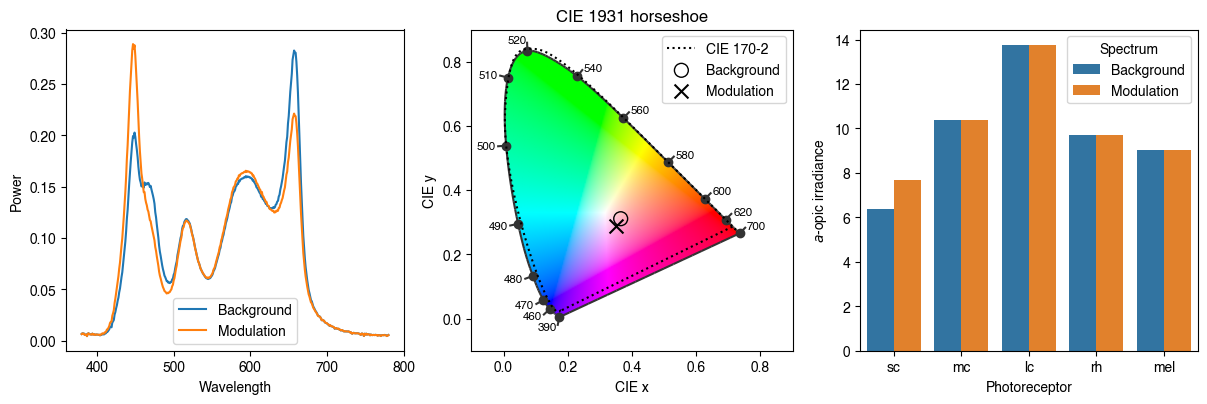

In [10]:
result_fig = ssp.plot_solution(amod)

Contrast modulations
--------------------

Multiprimary devices with good linearity, high resolution and rapid spectral switching capability may be used to present temporal modulations of photoreceptor-targeted contrast. Such stimuli have helped to shed light on how the pupil responds to input from different photoreceptors as a function of time (e.g., [Barrionuevo et al., 2016](https://jov.arvojournals.org/article.aspx?articleid=2565122); [Spitschan et al., 2014](https://www.pnas.org/doi/10.1073/pnas.1400942111)). 

To make contrast modulations, first define a stimulus profile with a sampling frequency in line with the switching capability of the stimulation device. In this case, its a 1 Hz sinusoid with 50 samples per cycle.


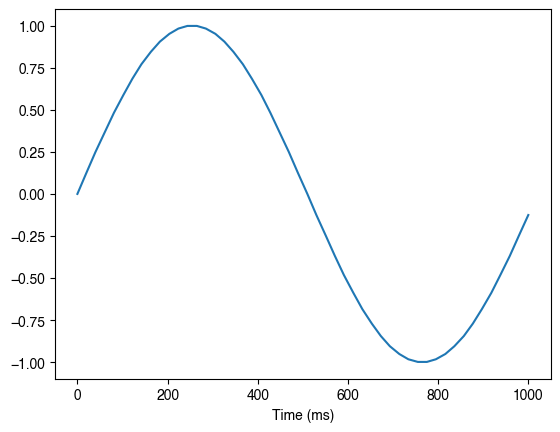

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def sinusoid_modulation(f, duration, Fs=50):
    """Generate a sinusoidal waveform"""
    x = np.arange(duration * Fs)
    return np.sin(2 * np.pi * f * x / Fs)

stimulus_profile = sinusoid_modulation(1, 1)
time = np.linspace(0, 1000, 50).astype('int')

plt.plot(time, stimulus_profile)
plt.xlabel('Time (ms)');

Now, define a problem. Here we define the background spectrum as all primaries at half-max power so we can maximise bidirectional contrast. Then we say that we want to ignore rods, minimize contrast on M-cones, L-cones and melanopsin, and modulate the S-cones.

In [12]:
# Load some example data for a 10-primary system
ssp = SSP.from_package_data('STLAB_1_York')

ssp.background = [.5] * ssp.nprimaries
ssp.ignore = ['rh']
ssp.minimize = ['mc', 'lc', 'mel']
ssp.modulate = ['sc']
ssp.print_problem()

************************************************************
*************** Silent Substitution Problem ****************
************************************************************
Device: STLAB_1 (binocular, left eye)
Ignoring: ['rh']
Minimising: ['mc', 'lc', 'mel']
Modulating: ['sc']
Target contrast: None
Background: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]




Next, choose a peak contrast value that is known to be in gamut and solve for each point in the stimulus profile. The algebraic approach is well suited here as it guarantees a linear uni-directional scaling of the primaries and is less computationally expensive than optimisation. 

In [15]:
peak_contrast = .4  # Known to be within gamut
solutions = []
for point in stimulus_profile:
    ssp.target_contrast = point * peak_contrast
    solutions.append(ssp.linalg_solve())

Plotting the forward projection of contrast for each solution in this case reveals a smooth S-cone modulation with little contrast splatter on the other photoreceptors.

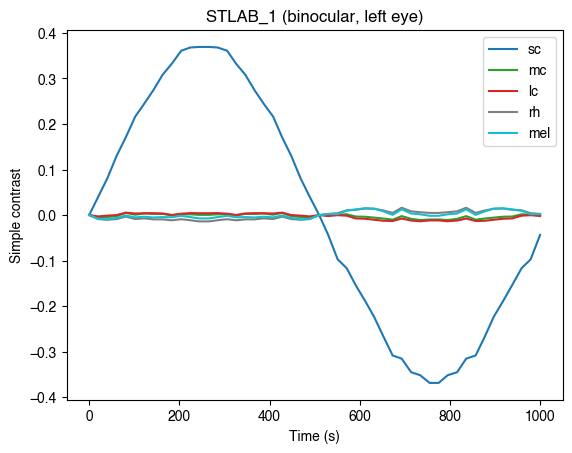

In [16]:
fig, ax = plt.subplots(1, 1)

splatter = [ssp.get_photoreceptor_contrasts(s) for s in solutions]
splatter = pd.concat(splatter, axis=1)    

for r, s in splatter.iterrows():
    ax.plot(time, s, label=r, color=ssp.observer.photoreceptor_colors[r])
        
    ax.set_ylabel('Simple contrast')
    ax.set_title(ssp.name)
    ax.set_xlabel('Time (s)')
    
plt.legend();

Finally, convert the solutions to settings compatible with the native resolution of the stimulation device.

In [17]:
device_settings = [ssp.w2s(s) for s in solutions]
device_settings = pd.DataFrame(device_settings, index=time)
with pd.option_context('display.max_rows', 10):
    print(device_settings)

         0     1     2     3     4     5     6     7     8     9
0     2047  2047  2047  2047  2047  2047  2047  2047  2047  2047
20    2242  2243  2012  1953  1883  2028  2142  2029  1946  2003
40    2435  2437  1978  1861  1723  2010  2236  2012  1847  1960
61    2621  2624  1945  1771  1567  1992  2327  1995  1750  1919
81    2798  2802  1914  1686  1418  1975  2413  1978  1659  1879
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...
918   1131  1126  2210  2488  2814  2135  1600  2131  2521  2252
938   1296  1292  2180  2408  2676  2119  1681  2116  2435  2215
959   1473  1470  2149  2323  2527  2102  1767  2099  2344  2175
979   1659  1657  2116  2233  2371  2084  1858  2082  2247  2134
1000  1852  1851  2082  2141  2211  2066  1952  2065  2148  2091

[50 rows x 10 columns]


Now you just need to tell the stimulation device to set the primary inputs to these values at the specified timepoints and it will produce the S-cone modulation shown above. 

Note that with this method one can also modulate multiple photoreceptors together.

In [18]:
ssp.ignore = ['rh']
ssp.minimize = ['mel']
ssp.modulate = ['sc', 'mc', 'lc']

In [19]:
peak_contrast = .2  # Known to be within gamut
solutions = []
for point in stimulus_profile:
    ssp.target_contrast = point * peak_contrast
    solutions.append(ssp.linalg_solve())

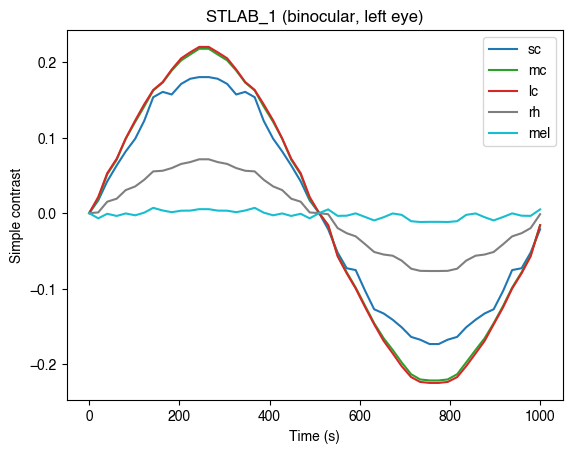

In [20]:
fig, ax = plt.subplots(1, 1)

splatter = [ssp.get_photoreceptor_contrasts(s) for s in solutions]
splatter = pd.concat(splatter, axis=1)    

for r, s in splatter.iterrows():
    ax.plot(time, s, label=r, color=ssp.observer.photoreceptor_colors[r])
        
    ax.set_ylabel('Simple contrast')
    ax.set_title(ssp.name)
    ax.set_xlabel('Time (s)')
    
plt.legend();

We can even modulate photoreceptors in counterphase.

In [21]:
peak_contrast = .2  # Known to be within gamut
solutions = []
for point in stimulus_profile:
    c = point * peak_contrast
    ssp.target_contrast = [-c, c, c]
    solutions.append(ssp.linalg_solve())

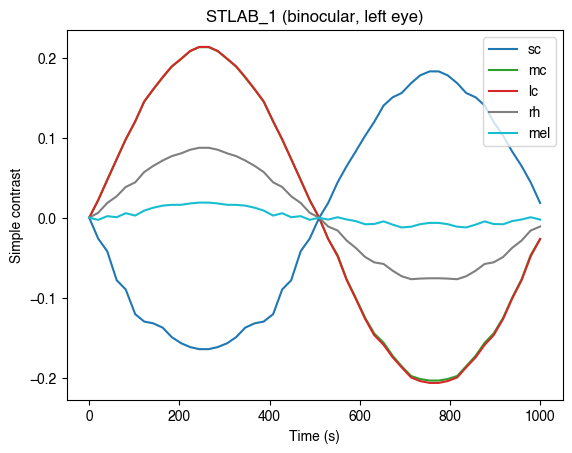

In [22]:
fig, ax = plt.subplots(1, 1)

splatter = [ssp.get_photoreceptor_contrasts(s) for s in solutions]
splatter = pd.concat(splatter, axis=1)    

for r, s in splatter.iterrows():
    ax.plot(time, s, label=r, color=ssp.observer.photoreceptor_colors[r])
        
    ax.set_ylabel('Simple contrast')
    ax.set_title(ssp.name)
    ax.set_xlabel('Time (s)')
    
plt.legend();